In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import io

In [3]:
filename = "UCLA_Microsoft_Data.xlsx"

ContosoRevData = pd.read_excel(filename, sheet_name=1)
FortuneGlobal2000 = pd.read_excel(filename, sheet_name=2)
TAM = pd.read_excel(filename, sheet_name=3)


## **0.Necessary Feature Engineering**

1. Adding Geo & Category market share

In [4]:
# Step 0: Filter for TAM data of Product A to E (exclude RevX)
product_tam = TAM[TAM['Metric_Name'].str.contains("Proj_TAM_Prod")].copy()

# Step 1: Aggregate TAM by Geo_Entity and Commercial_Category
geo_tam = product_tam[product_tam['Attr_Name'] == 'Geo_Entity'] \
    .groupby('Attr_Value')['Metric_Value'].sum().reset_index() \
    .rename(columns={'Attr_Value': 'Geo_Entity', 'Metric_Value': 'Geo_TAM_FY30'})

cat_tam = product_tam[product_tam['Attr_Name'] == 'Commercial_Category'] \
    .groupby('Attr_Value')['Metric_Value'].sum().reset_index() \
    .rename(columns={'Attr_Value': 'Commercial_Category', 'Metric_Value': 'Category_TAM_FY30'})

# Step 2: Merge aggregated TAM into ContosoRevData
ContosoRevData = ContosoRevData.merge(geo_tam, on='Geo_Entity', how='left')
ContosoRevData = ContosoRevData.merge(cat_tam, on='Commercial_Category', how='left')

# Step 3: Calculate FY30 Market Share
ContosoRevData['MarketShare_FY30_Geo'] = ContosoRevData['PotentialRevenue_FY30'] / ContosoRevData['Geo_TAM_FY30']
ContosoRevData['MarketShare_FY30_Category'] = ContosoRevData['PotentialRevenue_FY30'] / ContosoRevData['Category_TAM_FY30']



2. Adding FY22-26 revenue growth CAGR

In [5]:
ContosoRevData['Revenue_CAGR'] = (
    (ContosoRevData['TotalRevenue_FY26'] / ContosoRevData['TotalRevenue_FY22']) ** (1 / 4) - 1) * 100

3. Adding FY26 to FY30 revenue potential

In [6]:
ContosoRevData['Revenue_potential'] = ContosoRevData['PotentialRevenue_FY30'] - ContosoRevData['TotalRevenue_FY26']

In [7]:
ContosoRevData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         50000 non-null  int64  
 1   Geo_Entity                 50000 non-null  object 
 2   Area_National              50000 non-null  object 
 3   Area_Admin                 19100 non-null  object 
 4   Area_Urban                 50000 non-null  object 
 5   Commercial_Category        50000 non-null  object 
 6   Commercial_Stream          50000 non-null  object 
 7   Commercial_Specialty       50000 non-null  object 
 8   MarketDomain               50000 non-null  object 
 9   MarketTier_new             0 non-null      float64
 10  MarketTier_FY26            50000 non-null  object 
 11  MarketTier_FY25            50000 non-null  object 
 12  MarketTier_FY24            50000 non-null  object 
 13  MarketTier_FY23            50000 non-null  obj

In [8]:
# ===============================
# Define numeric columns for modeling
# ===============================
num_cols = [
    'MarketShare_FY30_Geo',
    'MarketShare_FY30_Category',
    'Revenue_CAGR',        # correct name
    'Revenue_potential',
    'TotalRevenue_FY26',   # revenue scale
]

# sanity check
ContosoRevData[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MarketShare_FY30_Geo,50000.0,2.363855e-04,1.100268e-03,1.351147e-07,1.130556e-05,3.797320e-05,1.323854e-04,6.783354e-02
MarketShare_FY30_Category,50000.0,9.011924e-05,4.803102e-04,2.785719e-07,9.076416e-06,2.180523e-05,6.183529e-05,5.943392e-02
Revenue_CAGR,50000.0,2.428915e+01,1.647239e+01,-2.564810e+01,1.287989e+01,2.261442e+01,3.396608e+01,1.340934e+02
Revenue_potential,50000.0,2.601303e+07,9.678146e+07,3.429300e+04,3.123951e+06,7.147706e+06,1.933162e+07,7.210167e+09
TotalRevenue_FY26,50000.0,9.807864e+06,3.422571e+07,8.774100e+04,1.164813e+06,2.484595e+06,6.787751e+06,1.604218e+09


## **1. Modeling Setup**

#### 1.0 Set Seed
We set a random seed at the start of the modeling section to ensure reproducibility.
Although Ward clustering itself is deterministic, other steps like PCA, K-Means initialization, or data sampling involve randomness. Fixing a seed makes sure that results (cluster assignments, KPIs, and visuals) remain consistent every time the notebook is re-run.

In [9]:
import numpy as np, random
np.random.seed(42)
random.seed(42)

### **1.1 KPI set up (Encapsulated)**

#### **1.1.1 Define KPIs**

Before building any segmentation or prediction model, it’s essential to define a clear set of success metrics. These metrics provide a consistent framework for evaluating whether a model actually improves business outcomes rather than just statistical accuracy. We propose success metrics from 2 aspects:

**a. Alignment & Segmentation Quality**
- Tier Potential Alignment (TPA):
Spearman rank correlation between PI_acct (a composite score that we calculate to represent the future growth potential of each customer account.) and assigned tier.

- Tier Compactness Index (TCI):
Measures within-tier variance of PI_acct or Revenue.

**b. Business Impact**
- Strategic Focus Index (SFI):
How concentrated a company’s revenue is in its most strategic customer segments.


---



##### **a.1 Tier Potential Alignment (TPA)**  

**Step 1: Calculating $ PI_{\mathrm{acct}} $ (Potential Index per Account)**  

We combine four normalized signals (runway, growth, and two market-share views) with weights:

$$
PI_{\mathrm{acct}}
= w_{\mathrm{runway}}\cdot R_{\mathrm{potential}}
+ w_{\mathrm{growth}}\cdot R_{\mathrm{CAGR}}
+ w_{\mathrm{share,geo}}\cdot MS_{\mathrm{FY30,Geo}}
+ w_{\mathrm{share,cat}}\cdot MS_{\mathrm{FY30,Category}}
$$

where all signals are normalized.

Example weights:

$$
w_{\mathrm{runway}}=0.40,\quad
w_{\mathrm{growth}}=0.30,\quad
w_{\mathrm{share,geo}}=0.15,\quad
w_{\mathrm{share,cat}}=0.15
$$

**Step 2: Calculating TPA (Tier Potential Alignment)**  

TPA is the **Spearman rank correlation** between account potential and the assigned tier (ordinal scale).  
Under the *Tier Policy* framework, tier ranks are derived automatically based on the model’s number of clusters (K) — for example, the cluster with the highest mean potential is mapped to Tier A, the next to Tier B, and so on:

$$
\mathrm{TPA}=\rho_s\!\big( PI_{\mathrm{acct}},~\mathrm{TierRank} \big)
$$

**Interpretation:**  
- $ \mathrm{TPA}=1 $ : perfect alignment (higher potential ⇒ higher tier)  
- $ \mathrm{TPA}=0 $ : no relationship  
- $ \mathrm{TPA}<0 $ : misalignment  



---


##### **a.2 Tier Compactness Index (TCI)**  

**Definition:**  
TCI measures how internally consistent (or compact) each customer tier is, indicating how similar accounts are within each tier compared to the overall population.  
A higher TCI means that accounts grouped within the same tier have **similar characteristics**, while a lower TCI indicates mixing of high- and low-potential customers.

We evaluate compactness from **two complementary dimensions**:

**(1) Potential-based Compactness — `TCI_PI`**

This version measures how homogeneous each tier is with respect to account potential ($ PI_{\mathrm{acct}} $):

$$
\mathrm{TCI_{PI}}
= 1 - \frac{\mathrm{WithinTierVar}\!\left( PI_{\mathrm{acct}} \right)}
{\mathrm{TotalVar}\!\left( PI_{\mathrm{acct}} \right)}
$$

It reflects how well the clustering separates customers by their *business potential*.

**(2) Revenue-based Compactness — `TCI_REV`**

This version measures compactness with respect to revenue ($ \mathrm{TotalRevenue}_{\mathrm{FY26}} $):

$$
\mathrm{TCI_{REV}}
= 1 - \frac{\mathrm{WithinTierVar}\!\left( \mathrm{TotalRevenue}_{\mathrm{FY26}} \right)}
{\mathrm{TotalVar}\!\left( \mathrm{TotalRevenue}_{\mathrm{FY26}} \right)}
$$

It reflects how concentrated and distinct each tier is in terms of *financial contribution*.

**Interpretation:**  
- $ \mathrm{TCI}=1 $ : tiers are tight and well-separated  
- $ \mathrm{TCI}=0 $ : tiers are random or overlapping  
- $ \mathrm{TCI}<0 $ : within-tier variance exceeds total variance (poor grouping)  

**Intuition:**  
If customers within the same tier have very similar potential or revenue (low within-tier variance), and customers across tiers differ strongly (high total variance), the segmentation is compact and meaningful — reflected by higher $ \mathrm{TCI_{PI}} $ and $ \mathrm{TCI_{REV}} $ values.


---


##### **b. Strategic Focus Index (SFI)**  

**Definition:**  
SFI measures how much of total revenue is concentrated in the **most strategic tiers**.  
Under the *Tier Policy* framework, the definition of “strategic” automatically adapts to the number of tiers K —for example, taking the **top L tiers** (e.g., top 2) or **top x %** of tiers ranked by mean potential or revenue:

$$
\mathrm{SFI}
= \frac{\sum_{t \in \mathcal{S}} \mathrm{Revenue}(t)}
{\sum_{t \in \mathcal{A}} \mathrm{Revenue}(t)}
$$

where $ \mathcal{S} $ is the set of strategic tiers and $ \mathcal{A} $ is the set of all tiers.

**Interpretation:**  
- **High SFI:** strong emphasis on top strategic segments (potentially efficient but watch concentration risk).  
- **Moderate SFI:** balanced focus across tiers.  
- **Low SFI:** diffuse portfolio, limited emphasis on priority segments.

#### **setting up kpi calculation**

In [10]:
import re
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# ---- helper: natural "Tier A" → "Tier Z" ordering ----
_TIER_RE = re.compile(r"^\s*Tier\s+([A-Z])\s*$")

def _natural_tier_order(labels):
    letters, others = [], []
    for lb in labels:
        m = _TIER_RE.match(str(lb))
        (letters if m else others).append((lb, m.group(1)) if m else str(lb))
    if letters:
        letters_sorted = [lb for lb,_ in sorted(letters, key=lambda x: x[1])]
        return letters_sorted + sorted(others)
    return sorted(others)

# ---- helper: TCI calculation ----
def _tci_from_value(df: pd.DataFrame, tier_col: str, value_col: str) -> float:
    """TCI = 1 - WithinTierVar(X) / TotalVar(X)"""
    d = df[[tier_col, value_col]].dropna()
    if d.empty:
        return np.nan
    x = d[value_col].values
    tot_var = np.var(x, ddof=0)
    if tot_var <= 0:
        return 0.0
    N = len(d)
    wt_var = sum((len(g) / N) * np.var(g[value_col].values, ddof=0)
                 for _, g in d.groupby(tier_col))
    tci = 1.0 - (wt_var / tot_var)
    return float(max(0.0, min(1.0, tci)))

# ---- main KPI computation ----
def compute_kpis(df, tier_col, pi_col, rev_col, sfi_param=2):
    """
    Compute Tier-Performance-Alignment (TPA), Tier-Compactness-Index (TCI),
    and Strategic-Focus-Index (SFI).

    Parameters
    ----------
    df : DataFrame
        Input data with columns for tier, PI, and revenue.
    tier_col, pi_col, rev_col : str
        Column names.
    sfi_param : int
        Number of top tiers (by natural order) to include in SFI.

    Returns
    -------
    dict with keys: 'TPA', 'TCI_PI', 'TCI_REV', 'SFI'
    """

    df = df.copy()

    # --- tier order ---
    unique_labels = list(df[tier_col].dropna().unique())
    ordered_labels = _natural_tier_order(unique_labels)

    # --- SFI ---
    tier_stats = (
        df.groupby(tier_col)
          .agg({pi_col: "mean", rev_col: "sum"})
          .rename(columns={pi_col: "pi_mean", rev_col: "rev_sum"})
    )
    total_rev = float(tier_stats["rev_sum"].sum() + 1e-12)
    L = max(0, int(sfi_param))
    strategic_tiers = ordered_labels[:L]
    sfi_rev = float(tier_stats.loc[tier_stats.index.isin(strategic_tiers), "rev_sum"].sum())
    SFI = sfi_rev / total_rev

    # --- TPA ---
    tier_rank_map = {label: rank for rank, label in enumerate(ordered_labels[::-1], start=1)}
    df["_tier_ordinal"] = df[tier_col].map(tier_rank_map).astype(float)
    valid = df[[pi_col, "_tier_ordinal"]].dropna()
    rho, _ = spearmanr(valid[pi_col], valid["_tier_ordinal"])
    TPA = float(rho)

    # --- TCI ---
    TCI_PI = _tci_from_value(df, tier_col=tier_col, value_col=pi_col)
    TCI_REV = _tci_from_value(df, tier_col=tier_col, value_col=rev_col)

    return {
        "TPA": round(TPA, 3),
        "TCI_PI": round(TCI_PI, 3),
        "TCI_REV": round(TCI_REV, 3),
        "SFI": round(SFI, 3),
        "Strategic_Tiers": strategic_tiers
    }


#### **calculate the pi_acct score**

In [11]:


# ---------- 1) Build PI_acct from normalized signals ----------
# signals
sig_cols = [
    "Revenue_potential",          # runway
    "Revenue_CAGR",               # growth
    "MarketShare_FY30_Geo",       # market-share (geo)
    "MarketShare_FY30_Category",  # market-share (category)
]

# z-score normalize (safe against zeros/NaNs)
Z = {}
for c in sig_cols:
    s = ContosoRevData[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=0)
    Z[c] = (s - mu) / (sd + 1e-12)

# weights (from definition)
w_runway, w_growth, w_geo, w_cat = 0.40, 0.30, 0.15, 0.15

ContosoRevData["PI_acct"] = (
    w_runway * Z["Revenue_potential"]
  + w_growth * Z["Revenue_CAGR"]
  + w_geo    * Z["MarketShare_FY30_Geo"]
  + w_cat    * Z["MarketShare_FY30_Category"]
).fillna(0.0)


#### **defining a composite score**

In [12]:
def composite_score(k):
    # Normalize so larger = better
    return (
        0.35 * k["TPA"] +
        0.35 * k["SFI"] +
        0.30 * (k["TCI_PI"] + k["TCI_REV"]) 
    )

#### **calculate current kpi and composite score**

In [13]:
# ---------- 2) Evaluate KPIs on FY26 baseline tiers ----------
# Use the existing FY26 tier labels; compute_kpis will internally rank tiers by mean PI
tier_col = "TierFY26"
df_base = ContosoRevData.rename(columns={"MarketTier_FY26": tier_col})

kpis_FY26 = compute_kpis(
    df_base,
    tier_col=tier_col,
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)

In [14]:
kpis_FY26

{'TPA': 0.259,
 'TCI_PI': 0.222,
 'TCI_REV': 0.469,
 'SFI': 0.807,
 'Strategic_Tiers': ['Tier A', 'Tier B']}

In [15]:
score_FY26 = composite_score(kpis_FY26)

In [16]:
score_FY26

0.5804

#### **Method 2: Direct split based on PI_acct - the potential score**

##### **Vanilla split**

We directly reassigned tiers based on PI_acct by ranking all companies from highest to lowest potential and allocating them into Tier A/B/C/D while preserving the original tier size distribution. This gives us a clean, PI-driven benchmark that shows what the tiers would look like if they were determined purely by potential.

In [17]:
def assign_direct_tiers(df, tier_col="MarketTier_FY26", 
                        pi_col="PI_acct", new_col="new_Tier_Direct"):

    df = df.copy()

    # 1. Get original tier distribution
    tier_counts = df[tier_col].value_counts().sort_index()

    # 2. Sort by PI descending (high PI → higher tier)
    df_sorted = df.sort_values(by=pi_col, ascending=False).reset_index(drop=False)
    original_index = df_sorted["index"]

    # 3. Assign new tiers in the same distribution
    new_tiers = []
    for tier, count in tier_counts.items():
        new_tiers += [tier] * count

    df_sorted[new_col] = new_tiers

    # 4. Restore original row order WITHOUT scrambling assignments
    df_final = df_sorted.set_index("index").sort_index()

    # 5. Attach new tier back to original dataframe
    df[new_col] = df_final[new_col]

    return df


In [18]:
ContosoRevData = assign_direct_tiers(ContosoRevData)


In [19]:
kpis_new = compute_kpis(
    ContosoRevData,
    tier_col="new_Tier_Direct",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)

In [20]:
kpis_new

{'TPA': 0.83,
 'TCI_PI': 0.536,
 'TCI_REV': 0.397,
 'SFI': 0.686,
 'Strategic_Tiers': ['Tier A', 'Tier B']}

In [21]:
score_new = composite_score(kpis_new)

In [22]:
score_new

0.8105

In [23]:
changed_direct = ContosoRevData[
    ContosoRevData["new_Tier_Direct"] != ContosoRevData["MarketTier_FY26"]
][["ID", "MarketTier_FY26", "new_Tier_Direct"]]

print("Changed companies:", len(changed_direct))
changed_direct


Changed companies: 20864


,ID,MarketTier_FY26,new_Tier_Direct
0,304930413,Tier B,Tier D
2,823903545,Tier B,Tier C
3,891289944,Tier B,Tier D
5,691572128,Tier A,Tier B
8,134673321,Tier C,Tier D
...,...,...,...
49986,421991614,Tier B,Tier C
49990,295261369,Tier B,Tier D
49991,272553792,Tier C,Tier D
49993,115300385,Tier A,Tier B


Comparing the new_tier_direct with original FY26 tier.

In [24]:
# -----------------------------------------
# 1. Compute composite scores
# -----------------------------------------
score_new = composite_score(kpis_new)
score_FY26 = composite_score(kpis_FY26)

# -----------------------------------------
# 2. Build comparison table
# -----------------------------------------
comparison_df = pd.DataFrame({
    "KPI": ["Composite Score", "TPA", "TCI_PI", "TCI_REV", "SFI"],
    "FY26 Baseline": [
        round(score_FY26, 4),
        kpis_FY26["TPA"],
        kpis_FY26["TCI_PI"],
        kpis_FY26["TCI_REV"],
        kpis_FY26["SFI"]
    ],
    "New_Tier_Direct": [
        round(score_new, 4),
        kpis_new["TPA"],
        kpis_new["TCI_PI"],
        kpis_new["TCI_REV"],
        kpis_new["SFI"]
    ]
})

comparison_df


,KPI,FY26 Baseline,New_Tier_Direct
0,Composite Score,0.5804,0.8105
1,TPA,0.2590,0.8300
2,TCI_PI,0.2220,0.5360
3,TCI_REV,0.4690,0.3970
4,SFI,0.8070,0.6860


From the comparison table, we can see that the new tiering approach delivers meaningful improvements in both the composite score and individual KPIs. 
However, two main issues exist.
- It results in 20,864 companies being reassigned, accounting for about 40% of the full base, which would introduce significant operational challenges. 
- In addition, this approach does not enforce an important business rule — each company’s tier should only move up or down by one level relative to its original FY26 tier. To make the solution more practical and implementable, we now incorporate this ±1 tier-movement constraint and further tighten the tier allocation process.

##### **Adding tier movement constraint split**

In this step, we create a PI-driven tiering baseline while preserving realism and operational feasibility. First, we capture the original FY26 tier distribution so the new tiers remain comparable in scale. Next, we sort companies by PI_acct and assign tiers purely based on performance ranking while matching the original tier proportions. Finally, we apply a ±1-tier movement constraint to ensure that each company’s new tier stays close to its original FY26 tier—reflecting the real-world requirement that large jumps are operationally impractical. This process yields a constrained, performance-aligned tier allocation that respects both distribution and movement limits.

In [25]:
# ------------------------------------------------------
# Tier order helpers
# ------------------------------------------------------
tier_to_int = {"Tier A":0, "Tier B":1, "Tier C":2, "Tier D":3}
int_to_tier = {v:k for k,v in tier_to_int.items()}

# ------------------------------------------------------
# STEP 1 — Compute original tier distribution
# ------------------------------------------------------
orig_counts = ContosoRevData["MarketTier_FY26"].value_counts().sort_index()

nA = orig_counts.get("Tier A", 0)
nB = orig_counts.get("Tier B", 0)
nC = orig_counts.get("Tier C", 0)
nD = orig_counts.get("Tier D", 0)

total = len(ContosoRevData)
assert (nA + nB + nC + nD) == total

# ------------------------------------------------------
# STEP 2 — Sort companies by PI_acct (high → low)
# ------------------------------------------------------
df_sorted = ContosoRevData.sort_values("PI_acct", ascending=False).reset_index(drop=True)

# Assign raw PI tiers based purely on ranking but respecting counts
raw = []

# Assign tiers according to original distribution
raw += ["Tier A"] * nA
raw += ["Tier B"] * nB
raw += ["Tier C"] * nC
raw += ["Tier D"] * nD

df_sorted["PI_Tier_Raw"] = raw

# Merge back to original order
ContosoRevData = ContosoRevData.merge(
    df_sorted[["ID","PI_Tier_Raw"]],
    on="ID",
    how="left"
)

# ------------------------------------------------------
# STEP 3 — Apply ±1 constraint
# ------------------------------------------------------
def constrain_tier(orig, proposed):
    """Ensure final tier is within ±1 of original."""
    o = tier_to_int[orig]
    p = tier_to_int[proposed]

    # Allowed positions
    allowed = [i for i in [o, o-1, o+1] if 0 <= i <= 3]

    # If proposed is valid → keep it
    if p in allowed:
        return int_to_tier[p]

    # Otherwise pick closest allowed tier
    closest = min(allowed, key=lambda x: abs(x - p))
    return int_to_tier[closest]

ContosoRevData["Tier_PI_Constrained"] = [
    constrain_tier(orig, raw)
    for orig, raw in zip(
        ContosoRevData["MarketTier_FY26"], 
        ContosoRevData["PI_Tier_Raw"]
    )
]


In [26]:
kpis_new_constrainted = compute_kpis(
    ContosoRevData,
    tier_col="Tier_PI_Constrained",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)

In [27]:
kpis_new_constrainted

{'TPA': 0.721,
 'TCI_PI': 0.492,
 'TCI_REV': 0.452,
 'SFI': 0.65,
 'Strategic_Tiers': ['Tier A', 'Tier B']}

In [28]:
score_constrained = composite_score(kpis_new_constrainted)

In [29]:
score_constrained

0.7630499999999999

In [30]:
changed_constrainted = ContosoRevData[
    ContosoRevData["Tier_PI_Constrained"] != ContosoRevData["MarketTier_FY26"]
]

print("Changed companies:", len(changed_constrainted))
display(changed_constrainted[["ID","MarketTier_FY26","Tier_PI_Constrained"]])

Changed companies: 20864


,ID,MarketTier_FY26,Tier_PI_Constrained
0,304930413,Tier B,Tier C
2,823903545,Tier B,Tier C
3,891289944,Tier B,Tier C
5,691572128,Tier A,Tier B
8,134673321,Tier C,Tier D
...,...,...,...
49986,421991614,Tier B,Tier C
49990,295261369,Tier B,Tier C
49991,272553792,Tier C,Tier D
49993,115300385,Tier A,Tier B


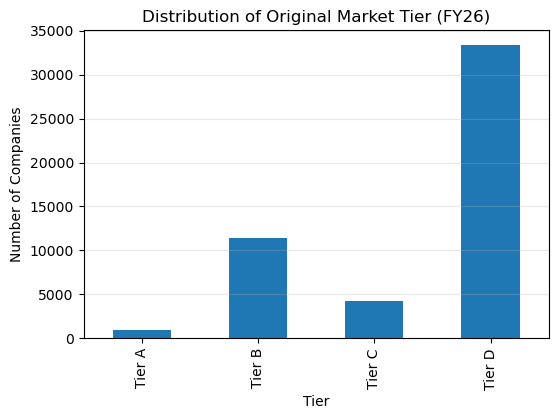

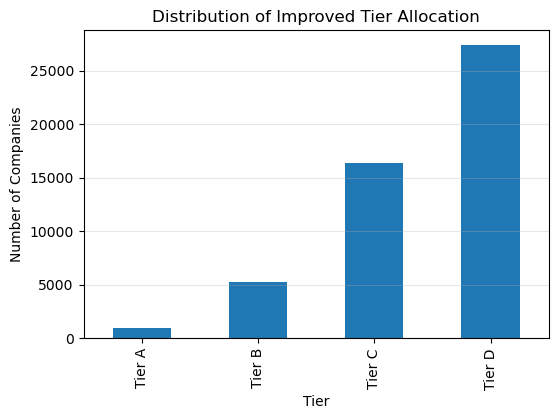

In [31]:
import matplotlib.pyplot as plt

# ================================
# 0. Plot distribution of Original Tier (MarketTier_FY26)
# ================================

plt.figure(figsize=(6,4))
ContosoRevData["MarketTier_FY26"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Original Market Tier (FY26)")
plt.xlabel("Tier")
plt.ylabel("Number of Companies")
plt.grid(axis='y', alpha=0.3)
plt.show()


# ================================
# 1. Plot distribution of ImprovedTier
# ================================

plt.figure(figsize=(6,4))
ContosoRevData["Tier_PI_Constrained"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Improved Tier Allocation")
plt.xlabel("Tier")
plt.ylabel("Number of Companies")
plt.grid(axis='y', alpha=0.3)
plt.show()




Compare the result of the original tier, vanilla split and constrained split.

In [32]:
# -----------------------------------------
# 1. Compute composite scores
# -----------------------------------------
score_FY26 = composite_score(kpis_FY26)
score_new = composite_score(kpis_new)
score_constrained = composite_score(kpis_new_constrainted)


# -----------------------------------------
# 2. Build comparison table
# -----------------------------------------
comparison_df = pd.DataFrame({
    "KPI": ["Composite Score", "TPA", "TCI_PI", "TCI_REV", "SFI"],

    "FY26 Baseline": [
        round(score_FY26, 4),
        kpis_FY26["TPA"],
        kpis_FY26["TCI_PI"],
        kpis_FY26["TCI_REV"],
        kpis_FY26["SFI"]
    ],

    "New_Tier_Direct": [
        round(score_new, 4),
        kpis_new["TPA"],
        kpis_new["TCI_PI"],
        kpis_new["TCI_REV"],
        kpis_new["SFI"]
    ],

    "Tier_PI_Constrained": [
        round(score_constrained, 4),
        kpis_new_constrainted["TPA"],
        kpis_new_constrainted["TCI_PI"],
        kpis_new_constrainted["TCI_REV"],
        kpis_new_constrainted["SFI"]
    ]
})

comparison_df


,KPI,FY26 Baseline,New_Tier_Direct,Tier_PI_Constrained
0,Composite Score,0.5804,0.8105,0.763
1,TPA,0.2590,0.8300,0.721
2,TCI_PI,0.2220,0.5360,0.492
3,TCI_REV,0.4690,0.3970,0.452
4,SFI,0.8070,0.6860,0.650


The constrained split still delivers meaningful KPI improvement — although naturally less dramatic than the direct PI-based assignment, since tier movement is restricted. However, two key issues remain:

- Tier distribution becomes distorted.
Because of the ±1 movement constraint, companies whose PI rank implies a +2/–2 change are forced into the “closest possible” tier. This causes structural drift in the distribution — especially an excessive concentration in Tier C — making the final tiering misaligned with the original distribution.

- Too many companies are reassigned.
Even under the constraint, 20,864 companies (≈40%) shift tiers. Such a large-scale movement is difficult to implement in real business operations, where stability and customer continuity are critical.

##### **Method 2 Summary**

1. Direct PI-Based Assignment
This approach delivers the highest KPI and composite score improvement and perfectly retains the original tier distribution. 
- However, it also reassigns a very large number of companies (≈40%), which is difficult to execute operationally. 
- More importantly, it violates the business rule that a company’s tier can only move up or down by one level, making the output unrealistic for real deployment.
2. Constrained PI-Based Assignment (±1 rule)
This method respects the tier movement constraint and still produces meaningful KPI improvement. Yet it suffers from two significant issues:

- It still moves ~40% of companies, which remains operationally challenging. 
- Because it forces companies into the “closest allowable tier,” it fails to maintain the original tier distribution, causing structural imbalances such as an oversized Tier C.


**Overall Conclusion**

PI_acct–driven tier assignment faces a fundamental trade-off:


- Maintaining tier distribution (important for headcount allocation and sales capacity planning)
- Preserving the ±1 movement rule (important for business continuity)


No simple PI-based ranking method satisfies the two simultaneously. This creates a dilemma, indicating that a more advanced optimization or hybrid rule-based approach is needed to balance KPI gains with operational feasibility.

#### **Method 3: Optimization + Decision Tree**

##### **Optimizing the tier allocation based on MarketTier_FY26 with guided local search**

Given the limitations observed in Method 2, we proceeded to explore local search optimization as a third approach. The goal was to preserve the original tier distribution while also enforcing the ±1 movement constraint, allowing controlled adjustments that improve KPIs without causing excessive operational disruption.
In this approach, we implement a four-phase tier-optimization algorithm that iteratively improves the assignment of accounts across Tier A–D under strict constraints. It evaluates each configuration using composite KPIs (TPA, TCI_PI, TCI_REV, SFI) and performs targeted swaps of “worst” and “best” accounts—first based on performance index (PI) and then revenue—to maximize the overall score. 
The optimizer progresses from deterministic single-worst/best swaps to stochastic pool-based swaps, resetting on improvements and stopping when reaching a performance plateau. Throughout, it enforces ±1 movement limits relative to original tiers and fixed Tier A/B counts. The final output is an optimized tier assignment that yields the best KPI composite score found during the search.

In [33]:
import numpy as np
import pandas as pd


# ==========================================================
# PRETTY PRINT
# ==========================================================
def pretty_print(phase, it, score, k):
    print(
        f"[{phase}] Iter {it:<6d} | "
        f"Score={score:7.4f} | "
        f"TPA={k['TPA']:>5.3f} | "
        f"TCI_PI={k['TCI_PI']:>5.3f} | "
        f"TCI_REV={k['TCI_REV']:>5.3f} | "
        f"SFI={k['SFI']:>5.3f}"
    )


# ==========================================================
# Utility: Worst / Best per tier
# ==========================================================
def find_worst_best(df, tier_col, value_col):
    tiers = ["Tier A", "Tier B", "Tier C", "Tier D"]
    worst, best = {}, {}
    for t in tiers:
        sub = df[df[tier_col] == t]
        if len(sub) == 0:
            worst[t], best[t] = None, None
            continue
        worst[t] = sub[value_col].idxmin()
        best[t] = sub[value_col].idxmax()
    return worst, best


# ==========================================================
# Utility: Worst / Best POOL
# ==========================================================
def find_pool(df, tier_col, value_col, pool_k=10):
    tiers = ["Tier A", "Tier B", "Tier C", "Tier D"]
    worst_pool, best_pool = {}, {}

    for t in tiers:
        sub = df[df[tier_col] == t]
        if len(sub) == 0:
            worst_pool[t], best_pool[t] = [], []
            continue
        worst_pool[t] = list(sub.nsmallest(pool_k, value_col).index)
        best_pool[t] = list(sub.nlargest(pool_k, value_col).index)

    return worst_pool, best_pool



# ==========================================================
# ⭐️ FOUR-PHASE OPTIMIZER with PRETTY PRINT ⭐️
# ==========================================================
def optimize_tiers_four_phase(
        df,

        tier_col="MarketTier_FY26",
        pi_col="PI_acct",
        rev_col="TotalRevenue_FY26",
        new_col="ImprovedTier",

        max_iter_each_phase=200000,
        plateau_limit=500,

        pool_k=10,
        print_every=300
    ):

    df = df.copy()
    N = len(df)

    # Tier mappings
    valid_tiers = ["Tier A", "Tier B", "Tier C", "Tier D"]
    tier_to_level = {"Tier A":0, "Tier B":1, "Tier C":2, "Tier D":3}

    # Original tiers
    orig_arr = df[tier_col].astype(str).to_numpy()

    working_arr = np.array([
        t if t in valid_tiers else "Tier D"
        for t in orig_arr
    ])

    # Tier A/B counts fixed
    countA = np.sum(orig_arr == "Tier A")
    countB = np.sum(orig_arr == "Tier B")

    # ------------------------
    # KPI Evaluator
    # ------------------------
    def evaluate(a):
        df["__temp_tier"] = a
        k = compute_kpis(df, "__temp_tier", pi_col, rev_col)
        return composite_score(k), k


    # ------------------------
    # INITIAL
    # ------------------------
    best_score, best_k = evaluate(working_arr)
    best_arr = working_arr.copy()

    print("\n========== INITIAL STATE ==========")
    pretty_print("INIT", 0, best_score, best_k)
    print("===================================\n")


    # ==========================================================
    # helper: ±1 constraint
    # ==========================================================
    def violates(idx):
        return abs(tier_to_level[working_arr[idx]] - tier_to_level[orig_arr[idx]]) > 1


    # ==========================================================
    # helper: swap(i,j)
    # ==========================================================
    def try_swap(i, j):
        nonlocal best_score, best_k, best_arr, working_arr

        if i is None or j is None or i == j:
            return False

        old_i, old_j = working_arr[i], working_arr[j]
        working_arr[i], working_arr[j] = old_j, old_i

        # ±1 original tier constraint
        if violates(i) or violates(j):
            working_arr[i], working_arr[j] = old_i, old_j
            return False

        # Tier A/B count constraint
        if (np.sum(working_arr=="Tier A") != countA) or \
           (np.sum(working_arr=="Tier B") != countB):
            working_arr[i], working_arr[j] = old_i, old_j
            return False

        new_score, new_k = evaluate(working_arr)

        if new_score >= best_score:
            best_score, best_k = new_score, new_k
            best_arr = working_arr.copy()
            return True
        else:
            working_arr[i], working_arr[j] = old_i, old_j
            return False



    # ==========================================================
    # ⭐️ PHASE 1 — PI SINGLE SWAP
    # ==========================================================
    print("========== Phase 1: PI Single Swap ==========")
    plateau = 0

    for it in range(1, max_iter_each_phase+1):

        df["__curTier"] = working_arr
        worst, best = find_worst_best(df, "__curTier", pi_col)

        improved = False
        for upper, lower in [("Tier A","Tier B"), ("Tier B","Tier C"), ("Tier C","Tier D")]:
            if try_swap(worst[upper], best[lower]):
                improved = True
                break

        if improved:
            plateau = 0
        else:
            plateau += 1

        if it % print_every == 0:
            pretty_print("P1", it, best_score, best_k)

        if plateau >= plateau_limit:
            print(f"--- Plateau at iter {it}, moving to Phase 2 ---")
            break

    working_arr = best_arr.copy()



    # ==========================================================
    # ⭐️ PHASE 2 — PI POOL SWAP
    # ==========================================================
    print("\n========== Phase 2: PI Pool Swap ==========")
    plateau = 0

    for it in range(1, max_iter_each_phase+1):

        df["__curTier"] = working_arr
        worst_pool, best_pool = find_pool(df, "__curTier", pi_col, pool_k)

        improved = False

        for upper, lower in [("Tier A","Tier B"), ("Tier B","Tier C"), ("Tier C","Tier D")]:
            wp, bp = worst_pool[upper], best_pool[lower]
            if len(wp)==0 or len(bp)==0:
                continue

            i = np.random.choice(wp)
            j = np.random.choice(bp)

            if try_swap(i, j):
                improved = True
                break

        if improved:
            plateau = 0
        else:
            plateau += 1

        if it % print_every == 0:
            pretty_print("P2", it, best_score, best_k)

        if plateau >= plateau_limit:
            print(f"--- Plateau at iter {it}, moving to Phase 3 ---")
            break

    working_arr = best_arr.copy()



    # ==========================================================
    # ⭐️ PHASE 3 — Revenue SINGLE
    # ==========================================================
    print("\n========== Phase 3: Revenue Single Swap ==========")
    plateau = 0

    for it in range(1, max_iter_each_phase+1):

        df["__curTier"] = working_arr
        worst, best = find_worst_best(df, "__curTier", rev_col)

        improved = False
        for upper, lower in [("Tier A","Tier B"), ("Tier B","Tier C"), ("Tier C","Tier D")]:
            if try_swap(worst[upper], best[lower]):
                improved = True
                break

        if improved:
            plateau = 0
        else:
            plateau += 1

        if it % print_every == 0:
            pretty_print("P3", it, best_score, best_k)

        if plateau >= plateau_limit:
            print(f"--- Plateau at iter {it}, moving to Phase 4 ---")
            break

    working_arr = best_arr.copy()



    # ==========================================================
    # ⭐️ PHASE 4 — Revenue POOL
    # ==========================================================
    print("\n========== Phase 4: Revenue Pool Swap ==========")
    plateau = 0

    for it in range(1, max_iter_each_phase+1):

        df["__curTier"] = working_arr
        worst_pool, best_pool = find_pool(df, "__curTier", rev_col, pool_k)

        improved = False

        for upper, lower in [("Tier A","Tier B"), ("Tier B","Tier C"), ("Tier C","Tier D")]:
            wp, bp = worst_pool[upper], best_pool[lower]
            if len(wp)==0 or len(bp)==0:
                continue

            i = np.random.choice(wp)
            j = np.random.choice(bp)
            if try_swap(i, j):
                improved = True
                break

        if improved:
            plateau = 0
        else:
            plateau += 1

        if it % print_every == 0:
            pretty_print("P4", it, best_score, best_k)

        if plateau >= plateau_limit:
            print(f"--- Plateau at iter {it} ---")
            break



    # ==========================================================
    # FINAL
    # ==========================================================
    print("\n========== Optimization Completed ==========")
    pretty_print("FINAL", 0, best_score, best_k)

    df[new_col] = best_arr
    return df

In [34]:
ContosoRevData = optimize_tiers_four_phase(
    ContosoRevData,
    tier_col="MarketTier_FY26",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    new_col="ImprovedTier",
    max_iter_each_phase=2000,
    plateau_limit=500,
    pool_k=20,
    print_every=100
)


========== INITIAL STATE ==========
[INIT] Iter 0      | Score= 0.5804 | TPA=0.259 | TCI_PI=0.222 | TCI_REV=0.469 | SFI=0.807

========== Phase 1: PI Single Swap ==========
[P1] Iter 100    | Score= 0.6074 | TPA=0.260 | TCI_PI=0.295 | TCI_REV=0.485 | SFI=0.807
[P1] Iter 200    | Score= 0.6165 | TPA=0.261 | TCI_PI=0.322 | TCI_REV=0.486 | SFI=0.808
[P1] Iter 300    | Score= 0.6196 | TPA=0.266 | TCI_PI=0.325 | TCI_REV=0.486 | SFI=0.809
[P1] Iter 400    | Score= 0.6219 | TPA=0.270 | TCI_PI=0.328 | TCI_REV=0.486 | SFI=0.809
[P1] Iter 500    | Score= 0.6241 | TPA=0.273 | TCI_PI=0.331 | TCI_REV=0.486 | SFI=0.810
[P1] Iter 600    | Score= 0.6268 | TPA=0.277 | TCI_PI=0.334 | TCI_REV=0.486 | SFI=0.811
[P1] Iter 700    | Score= 0.6291 | TPA=0.281 | TCI_PI=0.337 | TCI_REV=0.486 | SFI=0.811
[P1] Iter 800    | Score= 0.6310 | TPA=0.284 | TCI_PI=0.340 | TCI_REV=0.486 | SFI=0.811
[P1] Iter 900    | Score= 0.6330 | TPA=0.287 | TCI_PI=0.343 | TCI_REV=0.486 | SFI=0.811
[P1] Iter 1000   | Score= 0.6349 |

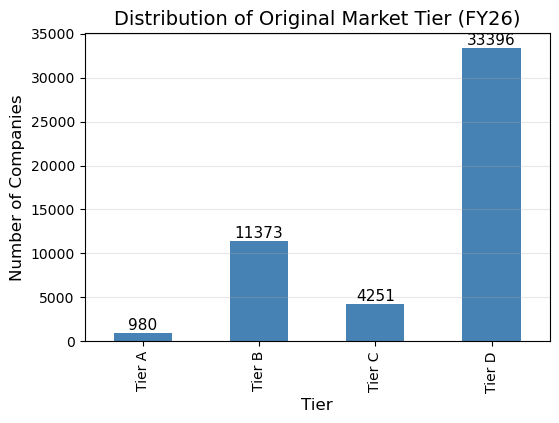

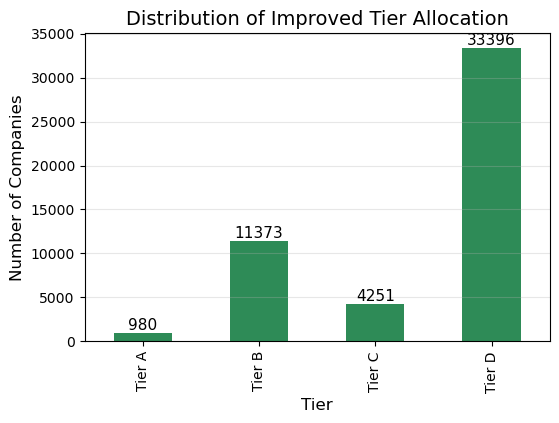

Changed companies: 2618


,ID,MarketTier_FY26,ImprovedTier
3,891289944,Tier B,Tier C
5,691572128,Tier A,Tier B
27,301153159,Tier B,Tier C
87,761064463,Tier C,Tier B
121,782165316,Tier C,Tier B
...,...,...,...
49908,170651032,Tier A,Tier B
49923,644439486,Tier C,Tier B
49924,847996744,Tier C,Tier B
49950,855657416,Tier B,Tier C


In [35]:
import matplotlib.pyplot as plt

# ================================
# 0. Plot distribution of Original Tier (MarketTier_FY26)
# ================================

plt.figure(figsize=(6,4))

ax = ContosoRevData["MarketTier_FY26"] \
        .value_counts() \
        .sort_index() \
        .plot(kind="bar", color="steelblue")

plt.title("Distribution of Original Market Tier (FY26)", fontsize=14)
plt.xlabel("Tier", fontsize=12)
plt.ylabel("Number of Companies", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# --- Add count labels ---
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.show()


# ================================
# 1. Plot distribution of ImprovedTier
# ================================

plt.figure(figsize=(6,4))

ax = ContosoRevData["ImprovedTier"] \
        .value_counts() \
        .sort_index() \
        .plot(kind="bar", color="seagreen")

plt.title("Distribution of Improved Tier Allocation", fontsize=14)
plt.xlabel("Tier", fontsize=12)
plt.ylabel("Number of Companies", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# --- Add count labels ---
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.show()


# ================================
# 2. Show changed IDs
# ================================

changed_opt = ContosoRevData[
    ContosoRevData["ImprovedTier"] != ContosoRevData["MarketTier_FY26"]
]

print("Changed companies:", len(changed_opt))
changed_opt[["ID","MarketTier_FY26", "ImprovedTier"]]

Compare the result of local search optimization and method 2.

In [36]:
# ============================================
# 1. Compute KPIs for FY26 Baseline
# ============================================
kpis_FY26 = compute_kpis(
    ContosoRevData,
    tier_col="MarketTier_FY26",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)
score_FY26 = composite_score(kpis_FY26)

# ============================================
# 2. Compute KPIs for Direct PI Assignment
# ============================================
kpis_direct = compute_kpis(
    ContosoRevData,
    tier_col="new_Tier_Direct",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)
score_direct = composite_score(kpis_direct)

# ============================================
# 3. Compute KPIs for Constrained PI Assignment
# ============================================
kpis_const = compute_kpis(
    ContosoRevData,
    tier_col="Tier_PI_Constrained",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)
score_const = composite_score(kpis_const)

# ============================================
# 4. Compute KPIs for Local-Search Optimized Result
# ============================================
kpis_improved = compute_kpis(
    ContosoRevData,
    tier_col="ImprovedTier",
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_param=2
)
score_improved = composite_score(kpis_improved)


# ============================================
# 5. Build the comparison table
# ============================================
comparison_df = pd.DataFrame({
    "KPI": ["Composite Score", "TPA", "TCI_PI", "TCI_REV", "SFI"],

    "FY26 Baseline": [
        round(score_FY26, 4),
        kpis_FY26["TPA"],
        kpis_FY26["TCI_PI"],
        kpis_FY26["TCI_REV"],
        kpis_FY26["SFI"]
    ],

    "New_Tier_Direct": [
        round(score_direct, 4),
        kpis_direct["TPA"],
        kpis_direct["TCI_PI"],
        kpis_direct["TCI_REV"],
        kpis_direct["SFI"]
    ],

    "Tier_PI_Constrained": [
        round(score_const, 4),
        kpis_const["TPA"],
        kpis_const["TCI_PI"],
        kpis_const["TCI_REV"],
        kpis_const["SFI"]
    ],

    "ImprovedTier": [
        round(score_improved, 4),
        kpis_improved["TPA"],
        kpis_improved["TCI_PI"],
        kpis_improved["TCI_REV"],
        kpis_improved["SFI"]
    ]
})

comparison_df


,KPI,FY26 Baseline,New_Tier_Direct,Tier_PI_Constrained,ImprovedTier
0,Composite Score,0.5804,0.8105,0.763,0.6512
1,TPA,0.2590,0.8300,0.721,0.2990
2,TCI_PI,0.2220,0.5360,0.492,0.3450
3,TCI_REV,0.4690,0.3970,0.452,0.5250
4,SFI,0.8070,0.6860,0.650,0.8160


##### **Method 3 Summary**

In summary, our proposed Method 3 — guided local search — delivers several clear advantages:
1. It produces meaningful KPI improvements across all dimensions.
2. It requires reassigning only about 5% of companies, compared with roughly 40% under the original approach.
3. It strictly satisfies all business rules, including the ±1 tier-movement constraint and the fixed tier-distribution requirement, while remaining flexible for incorporating additional rules in the future.
4. It converges within a very small number of iterations (approximately 7,000), demonstrating strong optimization efficiency.

**Overall Conclusion**
This method provides a highly effective balance between KPI enhancement and real-world business constraints.

##### **Decision Tree modeling based on the new tier - vanilla version**

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
import numpy as np

# -------------------------------
# Feature columns to use
# -------------------------------
feature_cols = [
    'TotalRevenue_FY26','TotalRevenue_FY25','TotalRevenue_FY24','TotalRevenue_FY23','TotalRevenue_FY22',
    'RevStreamX_FY26','RevStreamX_FY25','RevStreamX_FY24','RevStreamX_FY23','RevStreamX_FY22',
    'ProdCatA_Revenue_FY26','ProdCatB_Revenue_FY26','ProdCatC_Revenue_FY26','ProdCatD_Revenue_FY26','ProdCatE_Revenue_FY26',
    'PotentialRevenue_FY30','Geo_TAM_FY30','Category_TAM_FY30',
    'MarketShare_FY30_Geo','MarketShare_FY30_Category',
    'Revenue_CAGR','Revenue_potential','PI_acct'
]

# -------------------------------------------
# Input X and target y
# -------------------------------------------
X = ContosoRevData[feature_cols].fillna(0)   # handle missing values
y = ContosoRevData["ImprovedTier"]

# Encode target labels (Tier A/B/C/D)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split training / testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

In [38]:
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,            # interpretable limit
    min_samples_leaf=50,    # avoid overfitting
    random_state=42
)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=42)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = tree.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

      Tier A       0.87      0.94      0.90       245
      Tier B       0.82      0.90      0.86      2843
      Tier C       0.79      0.21      0.33      1063
      Tier D       0.91      0.97      0.94      8349

    accuracy                           0.89     12500
   macro avg       0.85      0.76      0.76     12500
weighted avg       0.88      0.89      0.87     12500

=== Confusion Matrix ===
[[ 231   14    0    0]
 [  35 2570    3  235]
 [   0  316  223  524]
 [   0  221   56 8072]]


In [40]:
rules = export_text(tree, feature_names=feature_cols)
print(rules)

|--- TotalRevenue_FY25 <= 5613241.00
|   |--- TotalRevenue_FY24 <= 2319004.50
|   |   |--- TotalRevenue_FY24 <= 1117616.50
|   |   |   |--- TotalRevenue_FY25 <= 1090028.50
|   |   |   |   |--- RevStreamX_FY22 <= 198101.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- RevStreamX_FY22 >  198101.00
|   |   |   |   |   |--- class: 3
|   |   |   |--- TotalRevenue_FY25 >  1090028.50
|   |   |   |   |--- RevStreamX_FY22 <= 52618.50
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- RevStreamX_FY22 >  52618.50
|   |   |   |   |   |--- class: 3
|   |   |--- TotalRevenue_FY24 >  1117616.50
|   |   |   |--- TotalRevenue_FY23 <= 1502679.50
|   |   |   |   |--- Category_TAM_FY30 <= 635345010688.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- Category_TAM_FY30 >  635345010688.00
|   |   |   |   |   |--- class: 3
|   |   |   |--- TotalRevenue_FY23 >  1502679.50
|   |   |   |   |--- Category_TAM_FY30 <= 635345010688.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- Categ

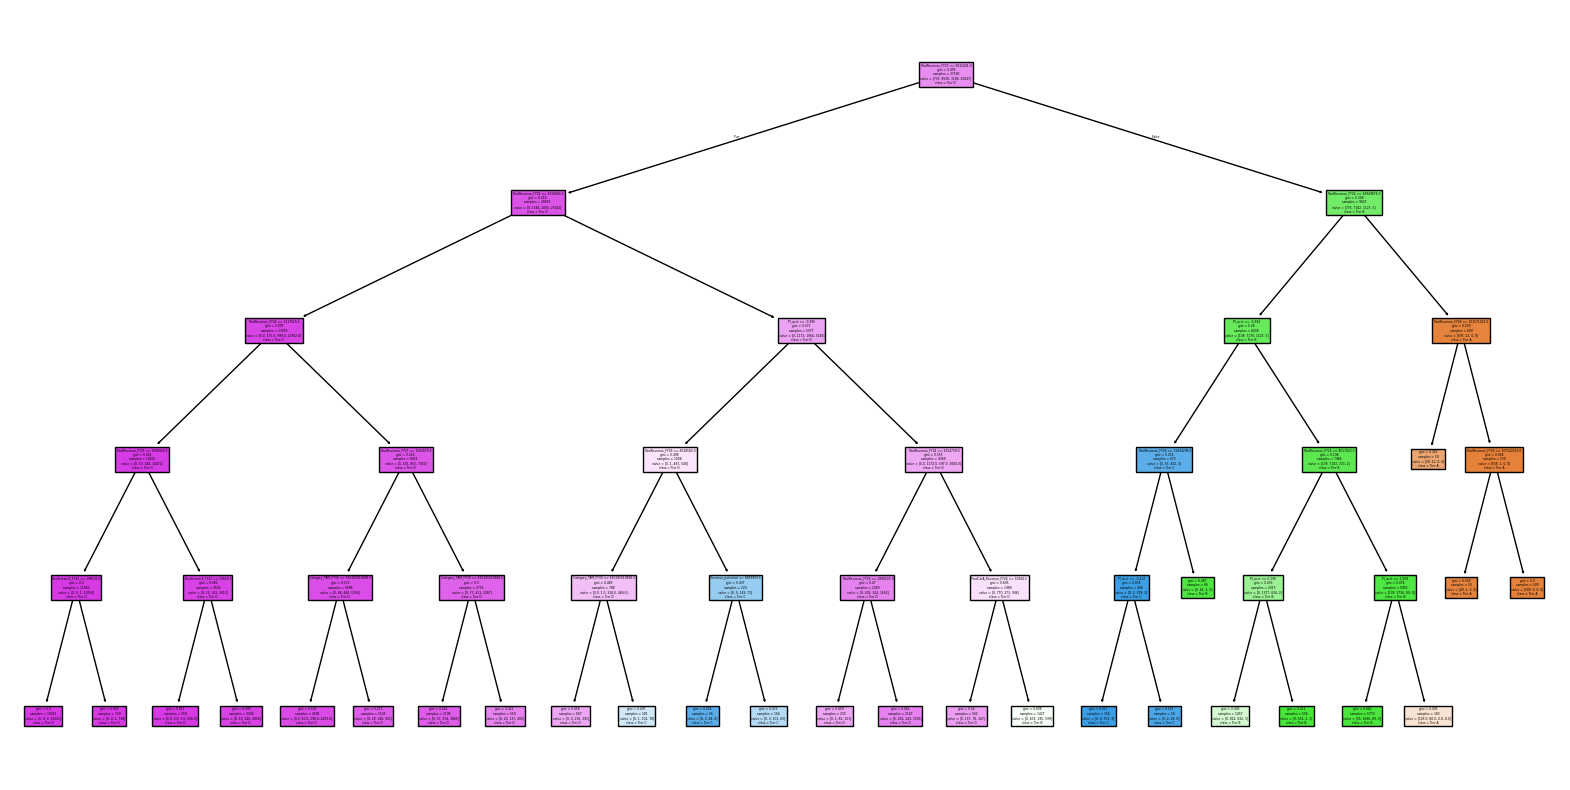

In [41]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=feature_cols, class_names=label_encoder.classes_, filled=True)
plt.show()

For the vanilla decision tree model, we could see that the result for Class C is very unconvincing, so we try to add a balance_class and up-sampling method to resolve this isseu

##### **Decision Tree modeling based on the new tier - with upsampling and balanced class weight**

In [42]:
from sklearn.utils import resample

# Extract Tier C & non-C
C_part = ContosoRevData[ContosoRevData["ImprovedTier"] == "Tier C"]
nonC_part = ContosoRevData[ContosoRevData["ImprovedTier"] != "Tier C"]

print("Original Tier C:", len(C_part))

# 2x upsample Tier C
C_up = resample(
    C_part,
    replace=True,
    n_samples=len(C_part) * 2,
    random_state=42
)

print("Upsampled Tier C:", len(C_up))

# Balanced final dataset
df_train_bal = pd.concat([nonC_part, C_up])
print("Balanced dataset size:", len(df_train_bal))


Original Tier C: 4251
Upsampled Tier C: 8502
Balanced dataset size: 54251


In [43]:
X_bal = df_train_bal[feature_cols].fillna(0)
y_bal = df_train_bal["ImprovedTier"]

from sklearn.preprocessing import LabelEncoder
le_bal = LabelEncoder()
y_bal_enc = le_bal.fit_transform(y_bal)


In [44]:
from sklearn.model_selection import train_test_split

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bal, y_bal_enc, test_size=0.25, random_state=42, stratify=y_bal_enc
)


In [45]:
from sklearn.tree import DecisionTreeClassifier

tree_balanced = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

tree_balanced.fit(Xb_train, yb_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, random_state=42)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_bal = tree_balanced.predict(Xb_test)

print("=== Balanced Model Classification Report ===")
print(classification_report(yb_test, y_pred_bal, target_names=le_bal.classes_))

print("\n=== Balanced Model Confusion Matrix ===")
print(confusion_matrix(yb_test, y_pred_bal))


=== Balanced Model Classification Report ===
              precision    recall  f1-score   support

      Tier A       0.77      1.00      0.87       245
      Tier B       0.89      0.71      0.79      2843
      Tier C       0.41      0.79      0.54      2126
      Tier D       0.94      0.78      0.85      8349

    accuracy                           0.77     13563
   macro avg       0.75      0.82      0.76     13563
weighted avg       0.85      0.77      0.79     13563


=== Balanced Model Confusion Matrix ===
[[ 244    1    0    0]
 [  73 2017  695   58]
 [   0  118 1688  320]
 [   0  139 1736 6474]]


We could see that while Tier C recall did improve, the precision of Tier C is still low, and the precision of Tier A also went down significantly. Trying SMOTE augmentation.

##### **Decision Tree modeling based on the new tier - SMOTE augmentation**

In [47]:
from imblearn.over_sampling import SMOTE

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)


In [49]:
# --- Apply SMOTE ---
sm = SMOTE(random_state=42, sampling_strategy='auto')  # 'auto' == balance all classes
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After  SMOTE:", np.bincount(y_train_sm))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE: [  735  8530  3188 25047]
After  SMOTE: [25047 25047 25047 25047]


In [50]:
from sklearn.tree import DecisionTreeClassifier

tree_smote = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

tree_smote.fit(X_train_sm, y_train_sm)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=42)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_sm = tree_smote.predict(X_test)

print("=== SMOTE Classification Report ===")
print(classification_report(y_test, y_pred_sm, target_names=label_encoder.classes_))

print("=== SMOTE Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_sm))


=== SMOTE Classification Report ===
              precision    recall  f1-score   support

      Tier A       0.84      1.00      0.91       245
      Tier B       0.89      0.73      0.80      2843
      Tier C       0.25      0.78      0.38      1063
      Tier D       0.97      0.76      0.85      8349

    accuracy                           0.76     12500
   macro avg       0.74      0.82      0.74     12500
weighted avg       0.89      0.76      0.80     12500

=== SMOTE Confusion Matrix ===
[[ 244    1    0    0]
 [  46 2067  666   64]
 [   0   75  830  158]
 [   0  170 1819 6360]]


In [52]:
from sklearn.tree import export_text

rules_sm = export_text(tree_smote, feature_names=feature_cols)
print(rules_sm)


|--- TotalRevenue_FY26 <= 66304306.00
|   |--- TotalRevenue_FY24 <= 2557684.25
|   |   |--- TotalRevenue_FY24 <= 1169598.38
|   |   |   |--- TotalRevenue_FY25 <= 1158655.00
|   |   |   |   |--- TotalRevenue_FY25 <= 1103413.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- TotalRevenue_FY25 >  1103413.00
|   |   |   |   |   |--- class: 3
|   |   |   |--- TotalRevenue_FY25 >  1158655.00
|   |   |   |   |--- MarketShare_FY30_Geo <= 0.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- MarketShare_FY30_Geo >  0.00
|   |   |   |   |   |--- class: 3
|   |   |--- TotalRevenue_FY24 >  1169598.38
|   |   |   |--- ProdCatA_Revenue_FY26 <= 26.00
|   |   |   |   |--- TotalRevenue_FY23 <= 1264688.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- TotalRevenue_FY23 >  1264688.00
|   |   |   |   |   |--- class: 3
|   |   |   |--- ProdCatA_Revenue_FY26 >  26.00
|   |   |   |   |--- PI_acct <= 0.08
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- PI_acct >  0.08
|   |   |   |

##### **Random Forest - vanilla model**

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ================================
# 1. Train Vanilla Random Forest
# ================================
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,       # fully grown trees
    random_state=42,
    n_jobs=-1             # use all cores
)

rf.fit(X_train, y_train)

# ================================
# 2. Evaluate
# ================================
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

print("=== Random Forest Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_rf))


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

      Tier A       0.97      0.96      0.96       245
      Tier B       0.90      0.88      0.89      2843
      Tier C       0.78      0.31      0.44      1063
      Tier D       0.91      0.98      0.94      8349

    accuracy                           0.90     12500
   macro avg       0.89      0.78      0.81     12500
weighted avg       0.90      0.90      0.89     12500

=== Random Forest Confusion Matrix ===
[[ 234   11    0    0]
 [   6 2504   47  286]
 [   0  187  329  547]
 [   0   88   48 8213]]


##### **Random Forest - Adding SMOTE and balanced class weight**

In [54]:
# ============================================================
# 1. Import Libraries
# ============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


# ============================================================
# 2. Prepare Data
# ============================================================
feature_cols = [
    'TotalRevenue_FY26','TotalRevenue_FY25','TotalRevenue_FY24','TotalRevenue_FY23','TotalRevenue_FY22',
    'RevStreamX_FY26','RevStreamX_FY25','RevStreamX_FY24','RevStreamX_FY23','RevStreamX_FY22',
    'ProdCatA_Revenue_FY26','ProdCatB_Revenue_FY26','ProdCatC_Revenue_FY26','ProdCatD_Revenue_FY26','ProdCatE_Revenue_FY26',
    'PotentialRevenue_FY30','Geo_TAM_FY30','Category_TAM_FY30',
    'MarketShare_FY30_Geo','MarketShare_FY30_Category',
    'Revenue_CAGR','Revenue_potential','PI_acct'
]

X = ContosoRevData[feature_cols].fillna(0)
y = ContosoRevData["ImprovedTier"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Show original
unique, counts = np.unique(y_train, return_counts=True)
print("Original training distribution:", dict(zip(unique, counts)))


# ============================================================
# 3. Apply SMOTE (fully automatic, NO manual settings)
# ============================================================
sm = SMOTE(
    sampling_strategy='auto',   # <-- AUTOMATIC balancing
    k_neighbors=3,
    random_state=42
)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Show new distribution
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("\nResampled training distribution:", dict(zip(unique_res, counts_res)))


# ============================================================
# 4. Train Random Forest
# ============================================================
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_res, y_train_res)

# ============================================================
# 5. Evaluate
# ============================================================
y_pred = rf.predict(X_test)

print("\n=== Random Forest + SMOTE (Auto) ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


Original training distribution: {0: 735, 1: 8530, 2: 3188, 3: 25047}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Resampled training distribution: {0: 25047, 1: 25047, 2: 25047, 3: 25047}

=== Random Forest + SMOTE (Auto) ===
              precision    recall  f1-score   support

      Tier A       0.93      0.98      0.95       245
      Tier B       0.91      0.84      0.87      2843
      Tier C       0.41      0.65      0.50      1063
      Tier D       0.95      0.90      0.93      8349

    accuracy                           0.87     12500
   macro avg       0.80      0.84      0.81     12500
weighted avg       0.89      0.87      0.88     12500


=== Confusion Matrix ===
[[ 239    6    0    0]
 [  18 2386  319  120]
 [   0  106  691  266]
 [   0  133  678 7538]]
